# Random things for building dataset / match filtering routines

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import scipy.signal as signal
import scipy
import xrsignal
import os
from scipy import io
from matplotlib import pyplot as plt
from numpy import matlib
import hvplot.xarray
from dask.distributed import Client

import seaborn as sns
from datetime import datetime
import ooipy
import kaooi

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

%load_ext autoreload
%autoreload 2

#### set up dask client

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 62.79 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43909,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 62.79 GiB
Comm: tcp://127.0.0.1:41271,Total threads: 4
Dashboard: http://127.0.0.1:43163/status,Memory: 7.85 GiB
Nanny: tcp://127.0.0.1:42441,


## Build / debug dataset creation script

### open dataset

In [3]:
ds_dir = '/datadrive/kauai/transmissions/200Hz_sensors/'
ds = xr.open_mfdataset(f'{ds_dir}real/*.nc') + 1j * xr.open_mfdataset(f'{ds_dir}imag/*.nc')
ds = ds.set_index({'time':['longtime', 'shorttime']})

In [48]:
single_hydrophone = ds.unstack().sel({'longtime':slice(2400, 4200)})['AXEC2.HDH'].mean('longtime').compute()

In [49]:
(20*np.log10(np.abs(single_hydrophone))).hvplot.line(x='shorttime')

:DynamicMap   [transmission]
   :Curve   [shorttime]   (AXEC2.HDH)

In [ ]:
x = (20*np.log10(np.abs(ds['AXEC2.HDH'].unstack().rolling(longtime=20).median()))).compute()

2023-09-05 20:24:44,017 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 6.51 GiB -- Worker memory limit: 7.85 GiB
2023-09-05 20:24:44,018 - distributed.worker.memory - WARNING - Worker is at 74% memory usage. Resuming worker. Process memory: 5.82 GiB -- Worker memory limit: 7.85 GiB
2023-09-05 20:24:44,040 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.83 GiB -- Worker memory limit: 7.85 GiB
2023-09-05 20:24:44,337 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 6.41 GiB -- Worker memory limit: 7.85 GiB
2023-09-05 20:24:44,738 - distributed.worker.memory - WARNING - Worker is at 72% memory usage. Resuming worker. Process memory: 5.68 GiB 

In [ ]:
x.hvplot(x='longtime', y='shorttime', rasterize=True, cmap='rocket')

In [68]:
x.sel({'longtime':3200}, method='nearest').hvplot.image(rasterize=True, clim=(50,70), cmap='rocket')

:DynamicMap   []
   :Image   [transmission,shorttime]   (AXEC2.HDH)

### test out some visualizations

### test xarray signal processing

In [ ]:
starttime = datetime.datetime(2023,6,14,0

## Recreate results from David

In [2]:
start_time = datetime(2023,8,11)
end_time = datetime(2023,8,11, 2)

hdata = ooipy.get_acoustic_data_LF(start_time, end_time, node='HYS14')
hdata_np = hdata.data

In [3]:
# construct replic
#fs,x = scipy.io.wavfile.read('tx_signal.wav')

#xep = signal.decimate(x, 12, zero_phase=True)

# test sequency generation

xep1 = kaooi.construct_replica_aliased(sampling_rate=200).values
xep2 = kaooi.construct_replica(sampling_rate=200).values
x_c1 = signal.hilbert(xep1)
x_c2 = signal.hilbert(xep2)

(0.0, 250.0)

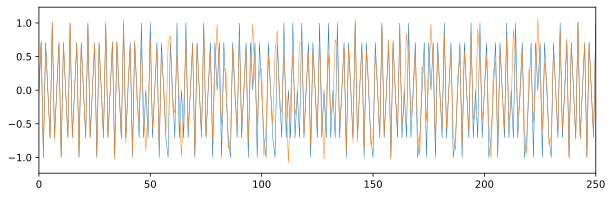

In [4]:
fig = plt.figure(figsize=(10,3))
plt.plot(x_c1.real, linewidth=0.5)
plt.plot(x_c2.real, linewidth=0.5)
plt.xlim([0,250])

In [6]:
d_nm = hdata_np - np.mean(hdata_np)

d_clip = d_nm[:int(np.floor(len(d_nm)/5456)*5456)]
d_c = signal.hilbert(d_clip);

d_match1 = signal.convolve(d_c, np.flipud(np.conjugate(x_c1)), mode='same');
d_match2 = signal.convolve(d_c, np.flipud(np.conjugate(x_c2)), mode='same');

d_rs1 = np.reshape(d_match1, (int(np.floor(len(d_match1)/5456)), 5456));
d_rs2 = np.reshape(d_match2, (int(np.floor(len(d_match2)/5456)), 5456));

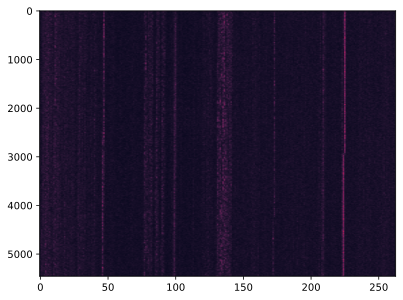

In [9]:
plt.imshow(np.abs(d_rs2).T, rasterized=True, cmap='rocket', aspect='auto')

#### *'a bunch of moving averages'*

In [7]:
def movmean(arr, window_size, axis):
    if window_size <= 0:
        raise ValueError("Window size must be positive")
    if axis >= arr.ndim:
        raise ValueError("Invalid axis")

    kernel = np.ones(window_size) / window_size
    smoothed_real = np.apply_along_axis(lambda x: np.convolve(np.real(x), kernel, mode='same'), axis, arr)
    smoothed_imag = np.apply_along_axis(lambda x: np.convolve(np.imag(x), kernel, mode='same'), axis, arr)
    
    smoothed = smoothed_real + 1j * smoothed_imag
    return smoothed

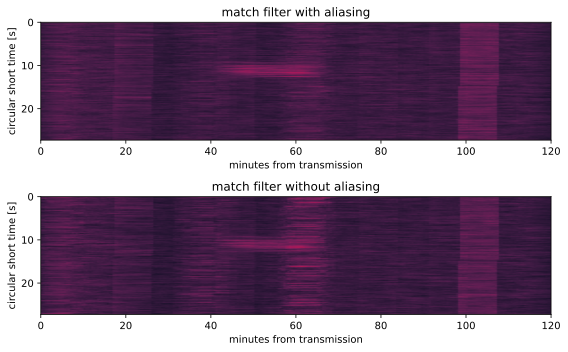

In [44]:
fig = plt.figure(figsize=(8,5))
plt.subplot(2,1,1)
plt.imshow(np.abs(movmean(d_rs1, 20, 0)).T, aspect='auto', cmap='rocket', extent=(0,120,27.28,0))
plt.xlabel('minutes from transmission')
plt.ylabel('circular short time [s]')
plt.title('match filter with aliasing')

plt.subplot(2,1,2)
plt.imshow(np.abs(movmean(d_rs2, 20, 0)).T, aspect='auto', cmap='rocket', extent=(0,120,27.28,0))
plt.xlabel('minutes from transmission')
plt.ylabel('circular short time [s]')
plt.title('match filter without aliasing')

plt.tight_layout()

(75.0, 150.0)

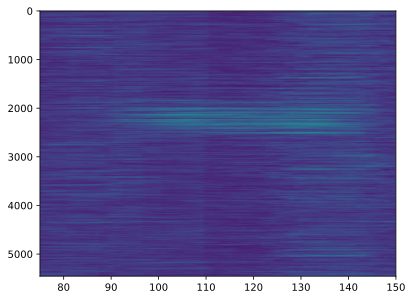

In [36]:
plt.imshow(np.abs(movmean(d_rs1, 20, 0)).T, aspect='auto')
plt.xlim([75, 150])

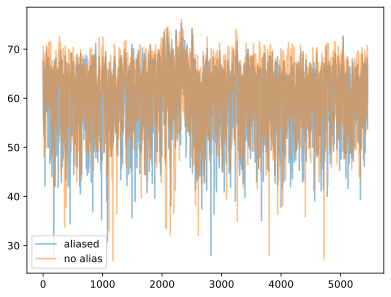

In [38]:
plt.plot(20*np.log10(np.abs(movmean(d_rs1, 20, 0))[135,:]), label='aliased', alpha=0.5)
plt.plot(20*np.log10(np.abs(movmean(d_rs2, 20, 0))[135,:]), label='no alias', alpha=0.5)
plt.legend()

In [55]:
d_avg = np.abs(movmean(d_rs,20,1));
#test_avg_med = median((abs(movmean(test,20,2))),1);

#test_avg = movmean((abs(movmean(test,20,2)))./median((abs(movmean(test,20,2))),1),20,1); %  a whole bunch of running averages to enhance signal


## build sequence functions in kaooi

In [50]:
import kaooi
import xrsignal
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
fs = 2e4
replica = kaooi.construct_replica_aliased(sampling_rate=fs, verbose=True)

bit_width 0.02666666666666667
seq_len 27.28
seq_len_samples 545600
samples_per_bit 533.3333333333334


In [89]:
replica_psd = xrsignal.welch(replica.chunk(), dim='time', nperseg=8192, fs=fs)[:,0]
replica_psd = (replica_psd/replica_psd.max()).rename({'time_frequency':'frequency'})

Text(0.5, 0, 'frequency [Hz]')

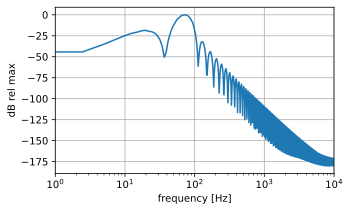

In [95]:
fig = plt.figure(figsize=(5,3))
(20*np.log10(replica_psd)).plot()
plt.xlim([1,1e4])
plt.xscale('log')
plt.grid()
plt.ylabel('dB rel max')
plt.xlabel('frequency [Hz]')

In [168]:
sampling_rate = 100000
carrier_frequency = 75
q = 2
bit_width = 2/75

In [169]:
seq_len = len(m)*bit_width
seq_len_samples = seq_len*sampling_rate
if seq_len_samples % 1 != 0:
    raise Exception(f'sequency length of {seq_len}s cannot be represented by integer number of samples for sampling rate of {sampling_rate} Hz. This is required for circular stacking')
else:
    seq_len_samples = int(seq_len_samples)
    
samples_per_bit = (bit_width)/(1/sampling_rate)

In [170]:
bin_seq = np.ones(seq_len_samples)

In [171]:
a = 0

for k in range(len(m)):
    b = int(np.floor((k+1)*samples_per_bit))
    bin_seq[a:b+1] = bin_seq[a:b+1]*m[k]
    a=b

# change from 1s and 0s to -1 and 1
bin_seq = -2*bin_seq + 1

In [172]:
t = np.arange(0, seq_len, 1/sampling_rate)
carrier = np.sin(2*np.pi*carrier_frequency*t)

In [173]:
replica = carrier*bin_seq

(0.0, 0.5)

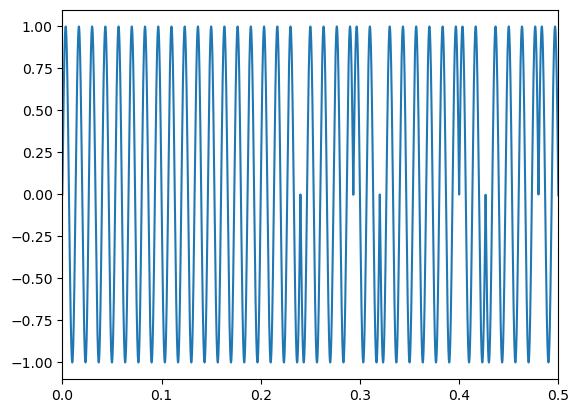

In [174]:
plt.plot(t, replica)
plt.xlim([0,0.5])

In [3]:
import numpy as np
import kaooi
from matplotlib import pyplot as plt

In [2]:
x_aliased = kaooi.construct_replica_aliased(sampling_rate=200)
x_noaliased = kaooi.construct_replica(sampling_rate=200)

(0.5, 1.0)

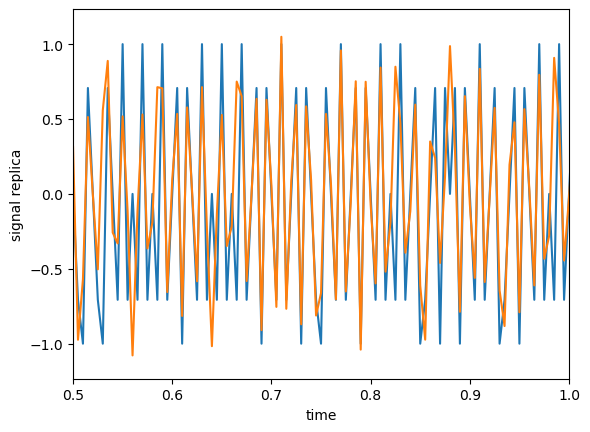

In [6]:
x_aliased.plot()
x_noaliased.plot()
plt.xlim([0.5,1])